In [117]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm_notebook as tqdm
import numpy as np
from scipy.special import softmax
from copy import copy
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from scipy import stats
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from utils import *
from dataloader import *
#from ssf.models import *
#from dataloader import *
from torch.optim import SGD

params = {
    'lr': 5e-3,
    'batch_size': 512,
    'epoches': 30,
}

use_cuda = True
torch.manual_seed(42)

if use_cuda:
    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': params['batch_size']}
test_kwargs = {'batch_size': params['batch_size']}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def get_latent(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x

    def forward(self, x):
        x = self.get_latent(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    pbr = tqdm((train_loader))
    for data, target, batch_idx in pbr:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbr.set_description(f'Loss {loss.item()}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target, idx in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    return test_loss

def measure(model, device, train_loader, metric_ls, metric_lb):
    model.eval()

    latent = np.zeros( (len(train_loader.dataset), 128) )
    prob = np.zeros( (len(train_loader.dataset), 10) )
    labels = np.zeros( (len(train_loader.dataset)) )
    
    with torch.no_grad():
        #latents = []
        #probs = []
        #labels = []
        for data, target, idx in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            latent_batch = model.get_latent(data)
            probs_batch = model(data)

            idx = idx.detach().cpu().numpy()
            latent[idx] = latent_batch.cpu().numpy()
            prob[idx] = probs_batch.cpu().numpy()
            labels[idx] = (target.cpu().numpy())
            
            #latents.append(latent_batch.cpu().numpy())
            #probs.append(probs_batch.cpu().numpy())
            #labels.append(target.cpu().numpy())
        
        #latent = np.concatenate(latents, 0)
        #prob = np.concatenate(probs, 0)
        #labels = np.concatenate(labels, 0)
        
        metric_ls.add_epoch(latent)
        metric_lb.add_epoch(prob)
        metric_lb.add_labels(labels)

def plot_loss(loss, label='test'):
    plt.plot(loss)
    plt.xlabel('Epoch')
    plt.ylabel(f'{label} loss')
    plt.grid()
    plt.show()


In [5]:
class LatentMetric:
  def __init__(self):
    self.res_epoches = []

  def add_epoch(self, latent):
    self.res_epoches.append(latent)

  def compute(self):
    pass


## Latent space metrics

**Variance2**: $ \sigma( \|M_i - E[M_i]\|_2 ) $

**Mean abs shift**: $ E[  ] $

In [248]:
class VarianceMetric(LatentMetric):
  def __init__(self):
    super().__init__()

  def compute(self):
    stds = np.std(self.res_epoches, 0)
    stds = np.linalg.norm(stds, axis=-1)
    return stds

class VarianceMetric2(LatentMetric):
    def __init__(self):
        super().__init__()

    def compute(self):
        center = np.mean(self.res_epoches, 0)
        dist = [np.linalg.norm(e-center, axis=-1) for e in self.res_epoches]
        stds = np.std(dist, 0)
        print(stds.shape)

        return stds

class MeanAbsShiftMetric(LatentMetric):
  def __init__(self):
    super().__init__()

  def compute(self):
    a = self.res_epoches[1:]
    adiff = np.linalg.norm(np.array(a[1:])-np.array(a[:-1]), axis=-1)

    return adiff.mean(0)

class VarAbsShiftMetric(LatentMetric):
  def __init__(self):
    super().__init__()

  def compute(self):
    a = self.res_epoches[1:]
    adiff = np.linalg.norm(np.array(a[1:])-np.array(a[:-1]), axis=-1)

    return adiff.std(0)

class JustDistanceMetric(LatentMetric):
  def __init__(self):
    super().__init__()

  def compute(self):
    center = np.mean(self.res_epoches, 2)
    dist = [np.linalg.norm(e-center[i].reshape(-1,1), axis=-1) for i, e in enumerate(self.res_epoches)]
    res = np.mean(dist, 0)
    return res

class VelocityMetric(LatentMetric):
    def __init__(self):
        super().__init__()

    def compute(self):
        a = self.res_epoches
        adiff = np.linalg.norm(np.array(a[1:])-np.array(a[:-1]), axis=-1)
        speed = 1/adiff
        velocity = speed[1:]-speed[:-1]
    
        res = velocity.mean(0)
        return res



In [240]:
class LabelMetric:
  def __init__(self):
    self.labels = None
    self.probs_epoches = []

  def add_epoch(self, probs_epoch):
    self.probs_epoches.append(probs_epoch)

  def add_labels(self, labels):
    self.labels = labels

  def compute(self):
    pass

class UncertantyMetric(LabelMetric):
    def __init__(self):
        super().__init__()
    
    def _unsertanty(self, probs, labels):
        lab_hot = labels.reshape(-1,1)
        probs = np.exp(probs)
        return np.max(probs, axis=1)
    
    def compute(self):
        unserts = [self._unsertanty(p, self.labels) for p in self.probs_epoches]
        unsert_mean = 1.0 - np.mean( unserts, 0 )
        return unsert_mean

    def compute0(self):
        unserts = [self._unsertanty(self.probs_epoches[-1], self.labels)]
        unsert_mean = 1.0 - np.mean( unserts, 0 )
        return unsert_mean

class UEntropyMetric(LabelMetric):
    def __init__(self):
        super().__init__()
    
    def _entropy(self, log_probs, labels):
        probs = np.exp(log_probs)
        return np.sum(probs*log_probs, axis=1)
    
    def compute(self):
        unserts = [self._entropy(p, self.labels) for p in [self.probs_epoches[-1]]]
        unsert_mean = -np.mean( unserts, 0 )
        return unsert_mean

class ConfidenceMetric(LabelMetric):
    def __init__(self):
        super().__init__()
    
    def _unsertanty(self, probs, labels):
        lab_hot = labels.reshape(-1,1)
        probs = np.exp(probs)
        return torch.gather(probs, lab_hot).reshape(-1) #np.max(probs, axis=1)

    def _entropy(self, log_probs, labels):
        probs = np.exp(log_probs)
        return np.sum(probs*log_probs, axis=1)

    def compute(self):
        unserts = [self._entropy(p, self.labels) for p in self.probs_epoches]
        unsert_mean = np.mean(unserts, 0)
        return unsert_mean

class VariabilityMetric(LabelMetric):
    def __init__(self):
        super().__init__()
    
    def _unsertanty(self, probs, labels):
        lab_hot = labels.reshape(-1,1)
        probs = np.exp(probs)
        return torch.gather(probs, lab_hot).reshape(-1) 

    def _entropy(self, log_probs, labels):
        probs = np.exp(log_probs)
        return np.sum(probs*log_probs, axis=1)

    def compute(self):
        unserts = [self._entropy(p, self.labels) for p in self.probs_epoches]
        unsert_mean = np.std(unserts, 0)
        return unsert_mean
        

In [155]:
def compute_correlation( ref_obj1, ref_obj2, class1, class2 ):
    
    m1 = copy.copy(ref_obj1)
    m1.__class__ = class1
    res1 = m1.compute()
    
    m2 = copy(ref_obj2)
    m2.__class__ = class2
    res2 = m2.compute()
    
    return np.corrcoef(res1, res2)[0,1]

def compute_r2( ref_obj1, ref_obj2, class1, class2 ):
    
    m1 = copy.copy(ref_obj1)
    m1.__class__ = class1
    res1 = m1.compute()
    
    m2 = copy(ref_obj2)
    m2.__class__ = class2
    res2 = m2.compute()

    res1 = (res1-res1.mean())/res1.std()
    res2 = (res2-res2.mean())/res2.std()
    
    #return r2_score(res1, res2)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(res1, res2)

    return r_value

def compute_spr( ref_obj1, ref_obj2, class1, class2 ):
    
    m1 = copy.copy(ref_obj1)
    m1.__class__ = class1
    res1 = m1.compute()
    
    m2 = copy.copy(ref_obj2)
    m2.__class__ = class2
    res2 = m2.compute()
    
    return stats.spearmanr(res1, res2).statistic

def corr_with_arr(ref_obj1, class1, res2):
    m1 = copy.copy(ref_obj1)
    m1.__class__ = class1
    res1 = m1.compute()

    return np.corrcoef(res1, res2)[0,1]

def get_metr_values(ref_obj1, class1):
    m1 = copy.copy(ref_obj1)
    m1.__class__ = class1
    res1 = m1.compute()
    return res1

In [9]:
def get_highest(scores, k = 15):
    return np.argsort(scores)[-k:]

def get_lowest(scores, k = 15):
    return np.argsort(scores)[:k]

def plot_images(dataset: torch.utils.data.Dataset, indices: np.ndarray) -> None:
    fig = plt.figure(figsize=(len(indices)*3, 3))
    for i, idx in enumerate(indices):
        img = dataset.data[idx]
        if img.shape[0] == 3:
            img = img.transpose((1, 2, 0))
        ax = fig.add_subplot(1, len(indices), i+1)
        ax.axis('off')
        ax.imshow(img)

    plt.show()

def plot_lh( ds, scores, name ):
    hs = get_highest(scores)
    lw = get_lowest(scores)
    print(f'Highest score by {name}')
    plot_images(ds, hs)
    print(f'Lowest score by {name}')
    plot_images(ds, lw)

def plot_lh_obj( ds, ref_obj, cls, name ):
    m = copy(ref_obj)
    m.__class__ = cls
    res = m.compute()

    plot_lh(ds, res, name)

In [10]:
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': False}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
else:
    cpu_kwargs = {'shuffle': False}
    train_kwargs.update(cpu_kwargs)
    test_kwargs.update(cpu_kwargs)


transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

## Second split forgetting

In [12]:
model = Net().to(device)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0)

#The name of the first and second split datasets. Keep these same
dataset1 = "mnist"
dataset2 = "mnist"


#Training parameters for first and second split training
weight_decay = 5e-4
peak_lr_pre = 0.1
peak_lr_ft = 0.1
batch_size = 512

#Label Noise Ratio in first and second split
label_noise_ratio_pre = 0.0
label_noise_ratio_ft = 0.0

#Model type and learning schedule
model_type = "resnet9" 
schedule = "triangle" 
seed = 0

#Extra Parameters, not needed
minority_1 = 0
minority_2 = 0

all_args = {"dataset1":dataset1, "dataset2":dataset2, "wd":weight_decay, "lr1":peak_lr_pre, "lr2":peak_lr_ft, 
            "noise_1":label_noise_ratio_pre, "noise_2":label_noise_ratio_ft, "model":model_type, "schedule":schedule,
            "minority_1":minority_1, "minority_2":minority_2, "seed":seed, "batch_size":batch_size, "log_factor":0,"seed_superclass":0}




In [17]:
#Dictionary containing first and second split data loaders, noise mask and other data-dependent quantities
pre_dict, ft_dict = return_loaders(all_args)
print(pre_dict.keys())
preloader = pre_dict["train_loader"]
ftloader = ft_dict["train_loader"]

dict_keys(['train_loader', 'test_loader', 'noise_mask', 'rare_mask', 'train_dataset'])


C:\Users\razvor\Documents\DS\Skoltech\Bayessian_project\dataloader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  try:


In [19]:

#Stage 1 Training
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler, EPOCHS = get_scheduler_epochs(all_args["schedule"], optimizer, preloader)

ret_pre = train_ssf(model, preloader, optimizer, scheduler, loss_fn, EPOCHS = EPOCHS, eval_every = True, eval_loader= preloader)

#torch.save(model.state_dict(), f"models/{all_args['dataset1']}/stage_1.pt")


#Stage 2 Training
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler, EPOCHS = get_scheduler_epochs(all_args["schedule"], optimizer, ftloader)


ret_ft = train_ssf(model, ftloader, optimizer, scheduler, loss_fn, EPOCHS = EPOCHS, eval_every = True, eval_loader= preloader)

#torch.save(model.state_dict(), f"models/{all_args['dataset1']}/stage_2.pt")

Epoch: 1 | Eval Loader Accuracy: 80.8367%
Epoch: 2 | Eval Loader Accuracy: 89.5133%
Epoch: 3 | Eval Loader Accuracy: 91.7633%
Epoch: 4 | Eval Loader Accuracy: 93.5700%
Epoch: 5 | Eval Loader Accuracy: 96.6767%
Epoch: 5 | Accuracy: 94.8667% | Loss: 3.47e-04
Epoch: 6 | Eval Loader Accuracy: 97.6367%
Epoch: 7 | Eval Loader Accuracy: 98.3067%
Epoch: 8 | Eval Loader Accuracy: 97.9800%
Epoch: 9 | Eval Loader Accuracy: 98.3933%
Epoch: 10 | Eval Loader Accuracy: 98.7100%
Epoch: 10 | Accuracy: 98.2933% | Loss: 1.05e-04
Epoch: 11 | Eval Loader Accuracy: 98.1400%
Epoch: 12 | Eval Loader Accuracy: 99.0533%
Epoch: 13 | Eval Loader Accuracy: 99.2433%
Epoch: 14 | Eval Loader Accuracy: 99.4700%
Epoch: 15 | Eval Loader Accuracy: 99.6333%
Epoch: 15 | Accuracy: 99.3233% | Loss: 4.35e-05
Epoch: 16 | Eval Loader Accuracy: 99.5200%
Epoch: 17 | Eval Loader Accuracy: 99.7500%
Epoch: 18 | Eval Loader Accuracy: 99.8000%
Epoch: 19 | Eval Loader Accuracy: 99.6667%
Epoch: 20 | Eval Loader Accuracy: 99.7900%
Epoch:

RuntimeError: Parent directory models/mnist does not exist.

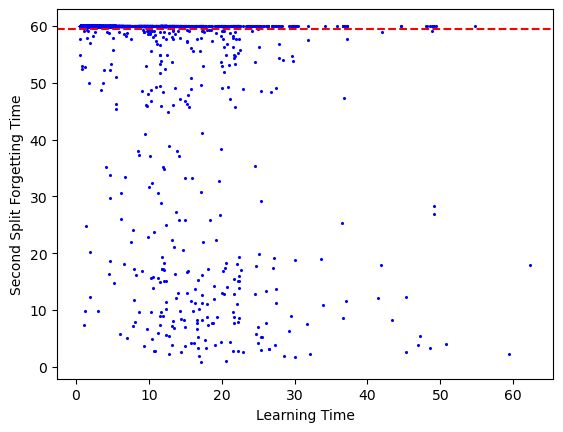

In [28]:
masks_pre = ret_pre["acc_mask"]
masks_ft = ret_ft["acc_mask"]
noise_mask = pre_dict["noise_mask"]

learn_epochs = get_first_epoch_where_we_learn_forever(masks_pre)
forget_epochs = get_first_epoch_where_we_forget_forever(masks_ft)
learn = learn_epochs + np.random.uniform(-0.5, 0.5, size = learn_epochs.shape)
forget = forget_epochs 
fg = forget_epochs.max()
forget[forget_epochs!=fg] = forget[forget_epochs!=fg] + np.random.uniform(-0.4, 0.4, size = forget_epochs[forget_epochs!=fg].shape)
plt.xlabel("Learning Time")
plt.ylabel("Second Split Forgetting Time")

plt.axhline(y=fg-0.5, color='r', linestyle='--')
plt.scatter(learn, forget, s= 1.5, c = "b")

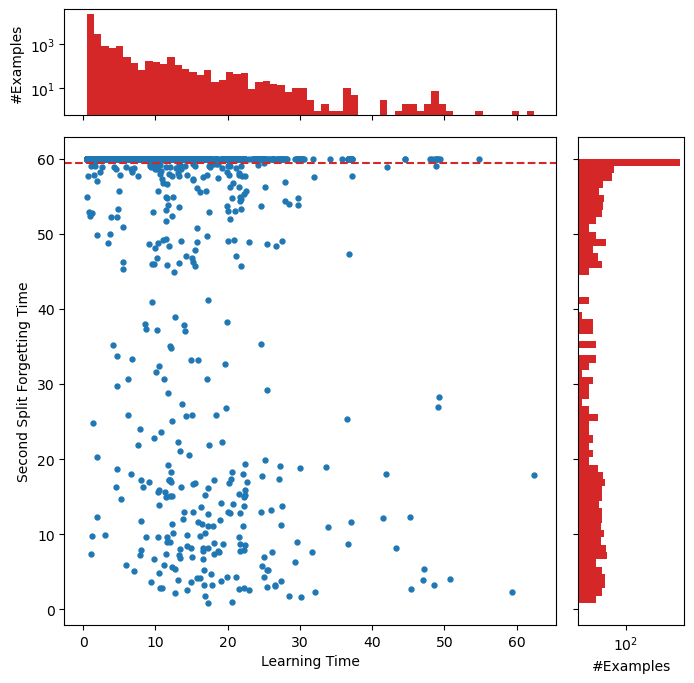

In [30]:
import matplotlib.gridspec as gridspec

x, y  = learn, forget
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:, :4])
ax_xDist = plt.subplot(gs[0, :4])#,sharex=ax_main)
ax_yDist = plt.subplot(gs[1:, 4])#,sharey=ax_main)

ax_main.scatter(x,y,marker='.',c='tab:blue',s=50)
ax_main.set(xlabel="Learning Time", ylabel="Second Split Forgetting Time")
ax_main.axhline(y=fg-0.5, color='tab:red', linestyle='--', c = 'tab:red')
ax_xDist.hist(x,bins=61,color='tab:red',align='mid')
ax_xDist.set(ylabel='#Examples')

ax_yDist.hist(y,bins=61,color='tab:red', orientation='horizontal',align='mid')
ax_yDist.set(xlabel='#Examples')

ax_xDist.set_yscale('log')
ax_yDist.set_xscale('log')
ax_yDist.set_yticklabels([])
ax_xDist.set_xticklabels([])


#plt.savefig("plots/mnist_vis.svg")
plt.show()

In [31]:
import pickle
with open('mnist_final.pickle', 'wb') as handle:
    pickle.dump([learn, forget], handle, protocol=pickle.HIGHEST_PROTOCOL)

## Training for latent space

In [71]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=params['lr'])

latentMetric = LatentMetric()
labelMetric = LabelMetric()

test_losses = []

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in tqdm(range(1, params['epoches'] + 1)):
    
    train(model, device, ftloader, optimizer, epoch)
    test_losses.append(test(model, device, ft_dict['test_loader']))
    
    measure(model, device, ftloader, latentMetric, labelMetric)
    
    scheduler.step()

C:\Users\razvor\AppData\Local\Temp\ipykernel_16552\3577538483.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1, params['epoches'] + 1)):


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\razvor\AppData\Local\Temp\ipykernel_16552\1936228384.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbr = tqdm((train_loader))


  0%|          | 0/59 [00:00<?, ?it/s]

C:\Users\razvor\AppData\Local\Temp\ipykernel_16552\1936228384.py:73: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data, target, idx in tqdm(train_loader):


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

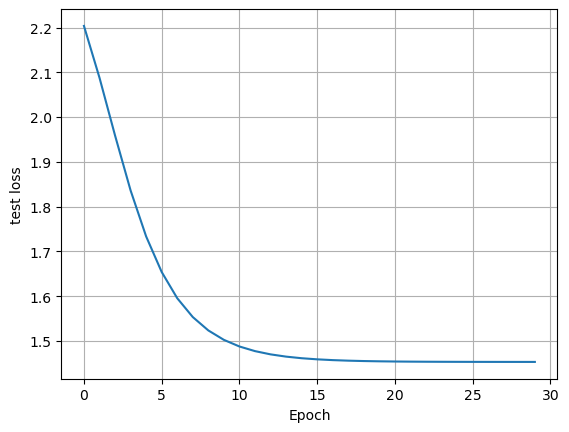

In [72]:
plot_loss(test_losses)

## PCA and TSNA analysis

In [156]:
hard_flag = (learn > 40) & (forget > 59)
hard_idx = np.where( hard_flag )[0][:10]
easy_idx = np.where( ~hard_flag )[0][:50]

In [157]:
pca = PCA(n_components = 2)
pca.fit( latentMetric.res_epoches[0] )

PCA(n_components=2)

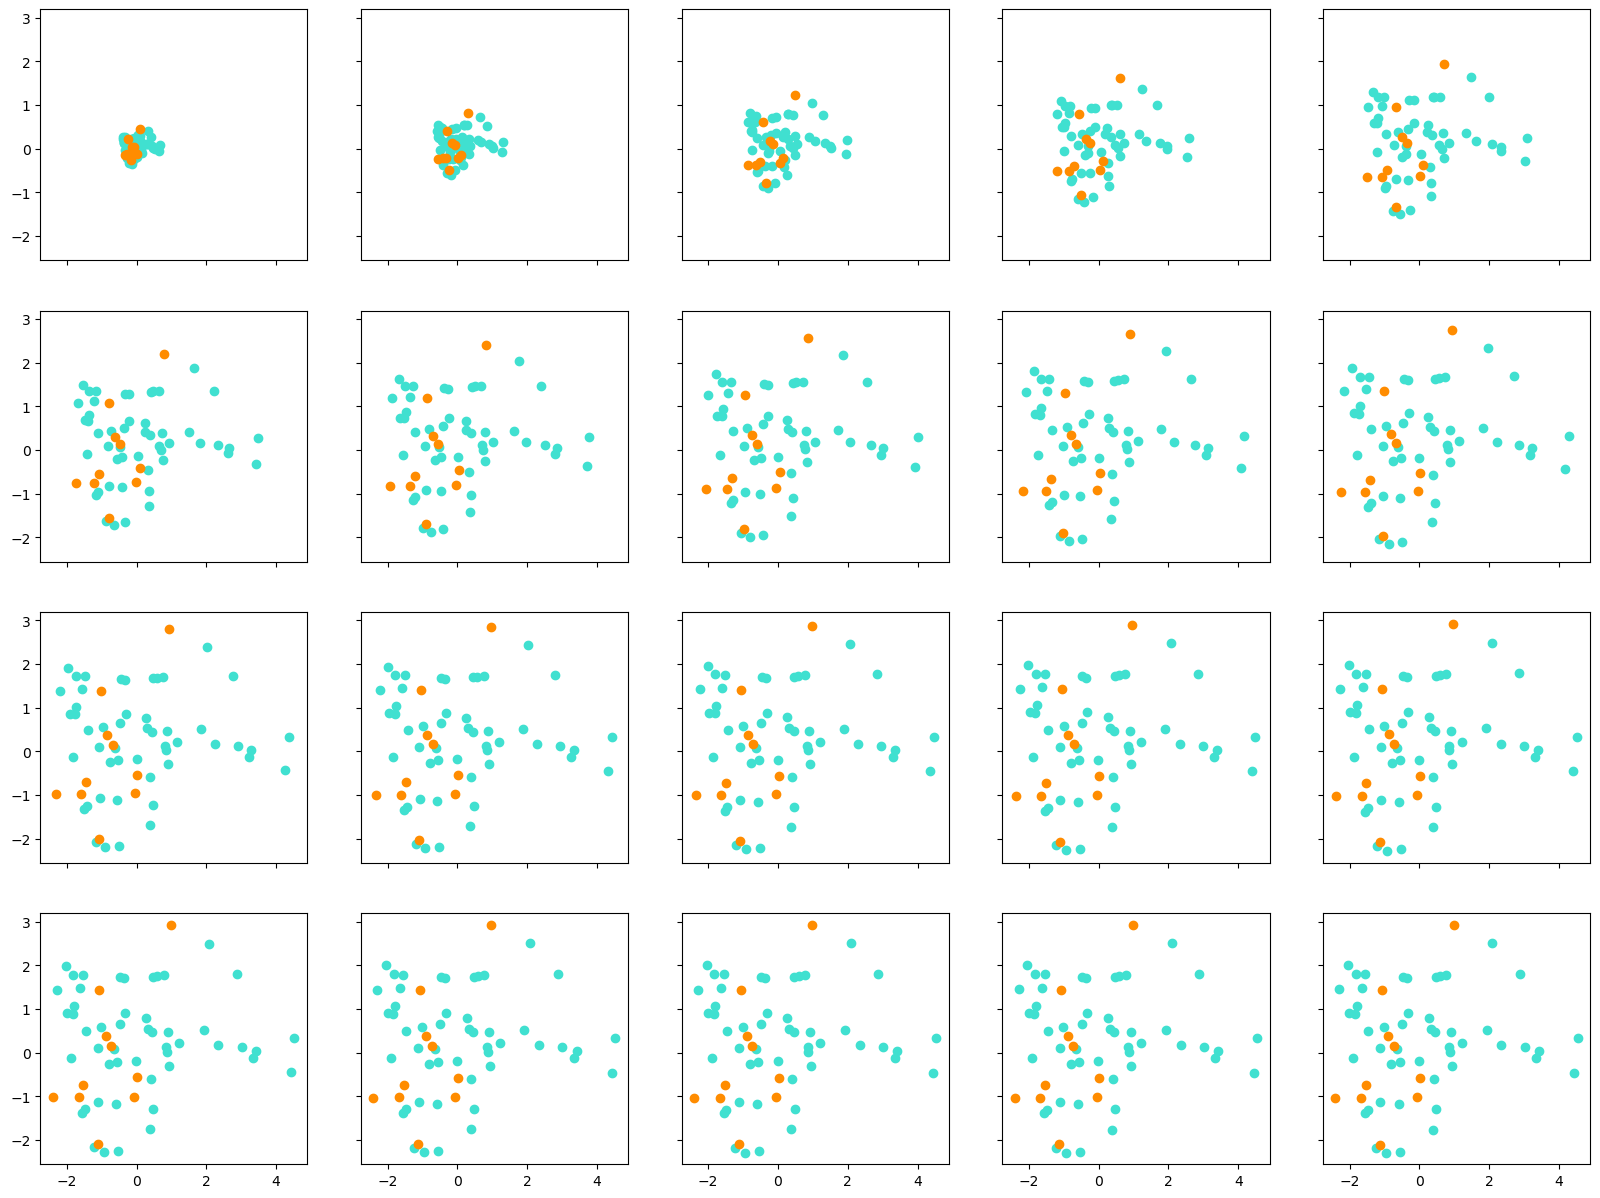

In [158]:
fig, axs = plt.subplots(4, 5, figsize=(20, 15), sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    #ax.set(xlabel='x-label', ylabel='y-label')

    latent_space_pca = pca.transform( latentMetric.res_epoches[i] )
    
    ax.scatter(
        latent_space_pca[easy_idx,0],
        latent_space_pca[easy_idx,1],
        color="turquoise",
        label="easy"
    )
    ax.scatter(
        latent_space_pca[hard_idx,0],
        latent_space_pca[hard_idx,1],
        color="darkorange",
        label="hard"
    )

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Correlation with SSF metric

In [209]:
complex_flag = (learn > 30) & (forget > 59)
mislabel_flag = (learn > 30) & (forget < 10)


In [218]:
named_metrics = {
    'Mean abs shift': MeanAbsShiftMetric,
    'Var abs shift': VarAbsShiftMetric,
    'Norm of variance': VarianceMetric,
    'Norm of variance(alt)': VarianceMetric2,
    'Velocity': VelocityMetric,
    'Distance': JustDistanceMetric
}

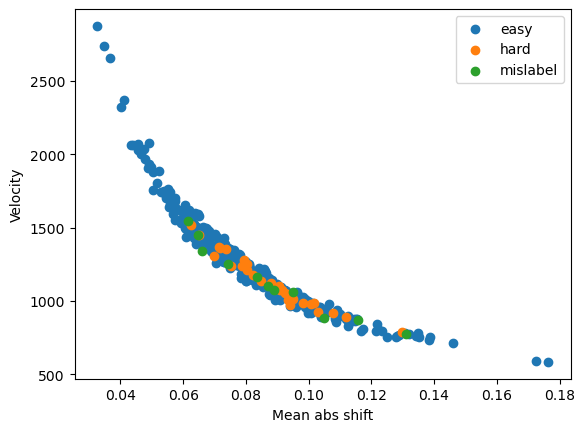

In [235]:
m1, m2 = get_metr_values( latentMetric, MeanAbsShiftMetric ), get_metr_values( latentMetric, VelocityVar )

plt.scatter(
    m1[ ~complex_metr ][:300],
    m2[ ~complex_metr ][:300],
    label='easy'
)
plt.scatter(
    m1[ complex_metr ][:200],
    m2[ complex_metr ][:200],
    label='hard'
)
plt.scatter(
    m1[ mislabel_flag ][:200],
    m2[ mislabel_flag ][:200],
    label='mislabel'
)
plt.xlabel('Mean abs shift')
plt.ylabel('Velocity')
plt.legend()

In [183]:
pd.DataFrame({
    'name': list(named_metrics.keys()),
    'correlation with SSF': [
        corr_with_arr( latentMetric, C, complex_metr )
        for C in named_metrics.values()
    ],
})

(30000,)
(30000,)


,name,correlation with SSF
0,Mean abs shift,0.003025
1,Var abs shift,0.002526
2,Norm of variance,0.002958
3,Norm of variance(alt),0.002641
4,Velocity,-0.006867
5,Distance,0.001080


Metrics do not really correlate but at least we can separate region with hard samples according to our metrics

## Correlation with uncertanty

In [219]:
# Correlation with uncalebrated uncertanty

pd.DataFrame({
    'name': list(named_metrics.keys()),
    'correlation with Uncertanty(max prob)': [
        compute_spr( labelMetric, latentMetric, UncertantyMetric, C )
        for C in named_metrics.values()
    ],
    'correlation with Uncertanty(entropy)': [
        compute_spr( labelMetric, latentMetric, UEntropyMetric, C )
        for C in named_metrics.values()
    ]
})

(30000,)
(30000,)
(30000,)
(30000,)


,name,correlation with Uncertanty(max prob),correlation with Uncertanty(entropy)
0,Mean abs shift,-0.766788,-0.918396
1,Var abs shift,-0.771354,-0.922616
2,Norm of variance,-0.768317,-0.919440
3,Norm of variance(alt),-0.771697,-0.922314
4,Velocity,0.742986,0.892242
5,Distance,-0.741434,-0.883433


### Correlation with variabilty and confidence
peper: 


In [243]:
pd.DataFrame({
    'name': list(named_metrics.keys()),
    'correlation with Confidence': [
        compute_spr( labelMetric, latentMetric, ConfidenceMetric, C )
        for C in named_metrics.values()
    ],
    'correlation with Variability': [
        compute_spr( labelMetric, latentMetric, VariabilityMetric, C )
        for C in named_metrics.values()
    ]
})

(30000,)
(30000,)
(30000,)
(30000,)


,name,correlation with Confidence,correlation with Variability
0,Mean abs shift,0.920660,0.912328
1,Var abs shift,0.925305,0.915514
2,Norm of variance,0.921750,0.913170
3,Norm of variance(alt),0.924887,0.915327
4,Velocity,-0.894723,-0.884531
5,Distance,0.889329,0.865326


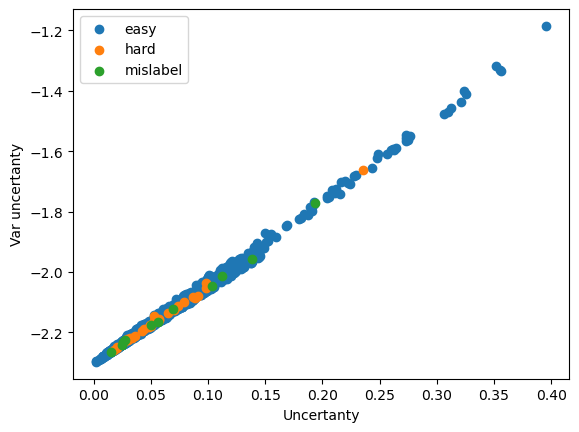

In [246]:
m1, m2 = get_metr_values( labelMetric, VariabilityMetric ), get_metr_values( labelMetric, ConfidenceMetric )

plt.scatter(
    m1[ ~complex_metr ][:1000],
    m2[ ~complex_metr ][:1000],
    label='easy'
)
plt.scatter(
    m1[ complex_metr ][:200],
    m2[ complex_metr ][:200],
    label='hard'
)
plt.scatter(
    m1[ mislabel_flag ][:200],
    m2[ mislabel_flag ][:200],
    label='mislabel'
)
plt.xlabel('Uncertanty')
plt.ylabel('Var uncertanty')
plt.legend()

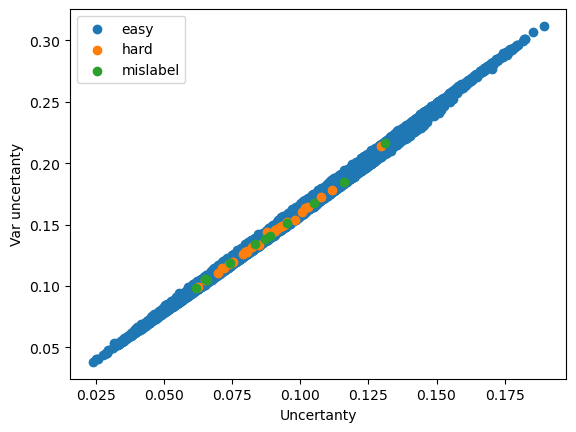

In [247]:
m1, m2 = get_metr_values( latentMetric, MeanAbsShiftMetric ), get_metr_values( latentMetric, VarAbsShiftMetric )

plt.scatter(
    m1[ ~complex_metr ],
    m2[ ~complex_metr ],
    label='easy'
)
plt.scatter(
    m1[ complex_metr ][:200],
    m2[ complex_metr ][:200],
    label='hard'
)
plt.scatter(
    m1[ mislabel_flag ][:200],
    m2[ mislabel_flag ][:200],
    label='mislabel'
)
plt.xlabel('Uncertanty')
plt.ylabel('Var uncertanty')
plt.legend()

## Visualization uncertant and confident expamples

(60000,)
Highest score by Velocity


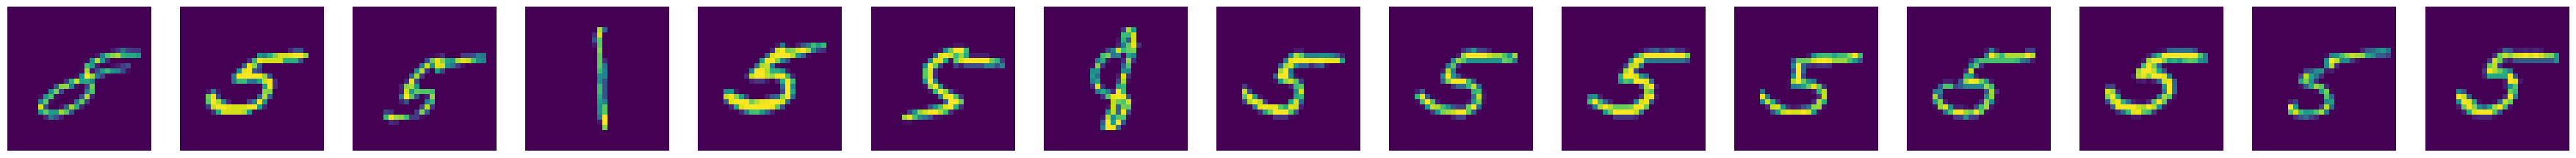

Lowest score by Velocity


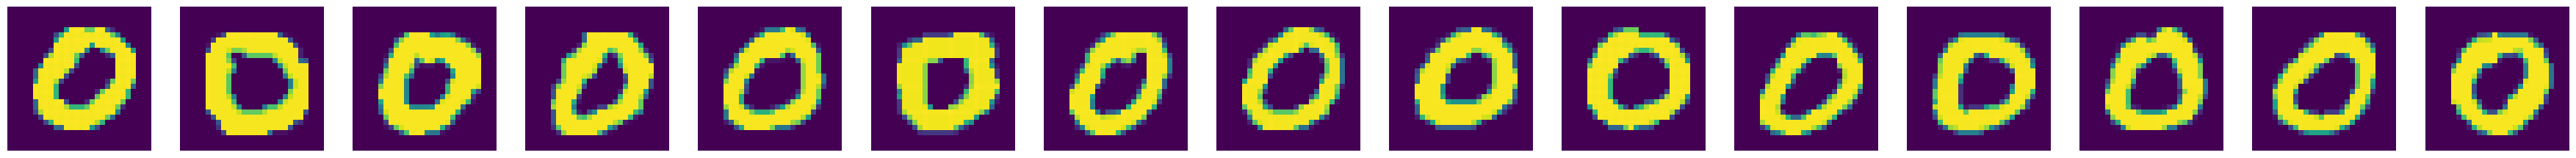

In [117]:
plot_lh_obj( dataset1_0, latentMetric, VelocityMetric, name = 'Velocity' )

Highest score by Variance(alt)


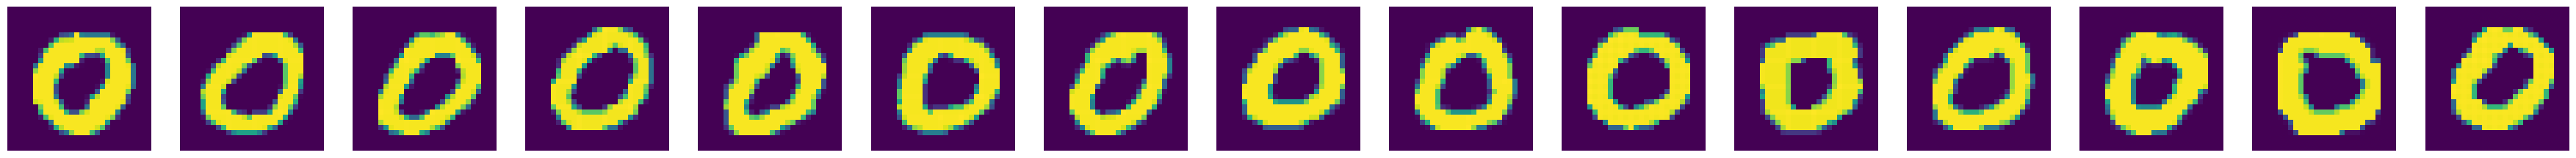

Lowest score by Variance(alt)


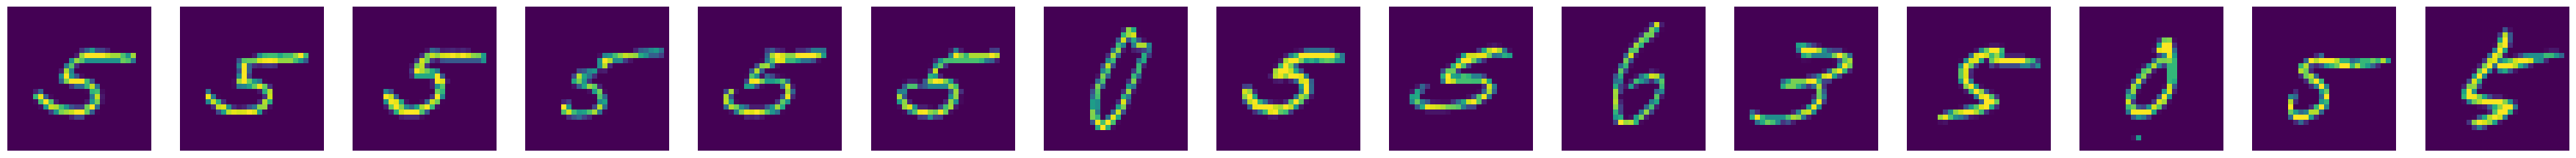

In [124]:
plot_lh_obj( dataset1_0, latentMetric, VarianceMetric2, name = 'Variance(alt)' )

Highest score by Entropy


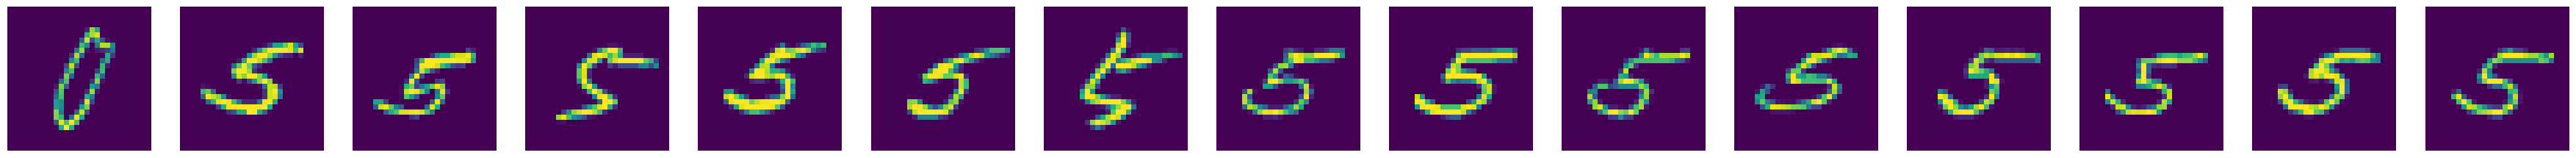

Lowest score by Entropy


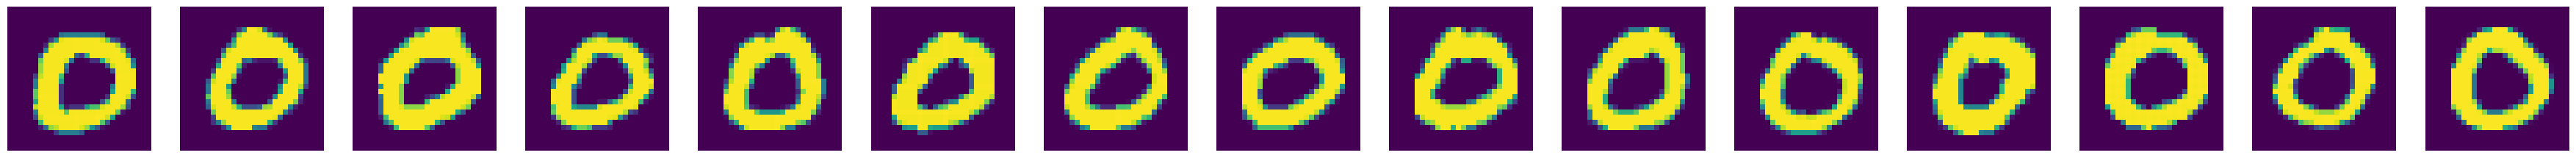

In [119]:
plot_lh_obj( dataset1_0, labelMetric, UEntropyMetric, name = 'Entropy' )